In [2]:
!pip install -U transformers tensorflow

In [3]:
!pip install accelerate -U

In [5]:
!pip install tf-keras

In [2]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf

In [4]:
df = pd.read_csv('/Users/mohsentaheri/Documents/JupyterNoteBook/combinednlpcat.csv')

In [5]:
# delete all the duplicated rows by keeping the first one and droping the rest
duplicated_rows = df[df.duplicated(keep=False)]
duplicated_rows

df = df.drop_duplicates(keep='first')
df

,news_ID,clean_text,category
0,NID_2023-01-19-02_3182,Forscher sehen enorm Aufholbedarf bei CO2 Entn...,Wissenschaft
1,NID_2023-01-19-04_5957,Museum Winsen Wie ein klein Museum groß Idee u...,Lkr. Harburg
2,NID_2023-01-19-04_6983,quartier in Harburg der neu Kümmerer beziehen ...,Harburg
3,NID_2023-01-19-04_3777,Grundsteuer Frist für Steuererklärung laufen a...,Norderstedt
4,NID_2023-01-19-06_4993,Kreis Pinneberg Elmshorn legen sein Vision der...,Pinneberg
...,...,...,...
985820,NID_2023-02-04-00_13776,Tagebuch in dies groß Zeit Björn Höcke in ein ...,Feuilleton
985821,NID_2023-02-04-00_3506,Digitales irgendwas passieren Berliner Festiva...,Feuilleton
985822,NID_2023-02-04-00_5566,Gedicht zeigen gut Nachricht der Glühbirne sei...,Feuilleton
985823,NID_2023-02-04-00_12457,schon laufen Nachschlag Zündnadeljets seit fas...,Feuilleton


In [6]:
# Remove rows where 'category' is NaN

total_rows = df.shape[0]
missing_rows = df['category'].isna().sum()
missing_percentage = (missing_rows / total_rows) * 100

print(f"Total rows: {total_rows}")
print(f"Missing rows in 'category': {missing_rows}")
print(f"Percentage of missing data in 'category': {missing_percentage:.2f}%")

# Assuming df is your DataFrame
print("Original number of rows:", df.shape[0])

# Remove rows where 'category' is NaN
df = df.dropna(subset=['category'])
print("Number of rows after removing missing values:", df.shape[0])

Total rows: 985738
Missing rows in 'category': 856
Percentage of missing data in 'category': 0.09%
Original number of rows: 985738
Number of rows after removing missing values: 984882


In [10]:
#Read the data
df.head()
print('Shape of original dataset:',df.shape)
unique_values = df['category'].nunique()
print('total number of categories is :',unique_values)

Shape of original dataset: (984882, 3)
total number of categories is : 69808


In [12]:
df.isnull().sum()

news_ID       0
clean_text    0
category      0
dtype: int64

In [14]:
value_counts = df['category'].value_counts()
value_counts

category
News                                                26432
Politik                                             26420
Sport                                               19741
Wirtschaft                                          19313
NRW                                                 18700
                                                    ...  
Elmshorn Fighting Pirates                               1
Baumgart Klaus                                          1
Prostata-Operation                                      1
hogwarts legacy                                         1
Sport,Fußball,3. Liga,SC Freiburg II,SC Freiburg        1
Name: count, Length: 69808, dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 984882 entries, 0 to 985824
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   news_ID     984882 non-null  object
 1   clean_text  984882 non-null  object
 2   category    984882 non-null  object
dtypes: object(3)
memory usage: 30.1+ MB


In [18]:
#extracting the top frequent categories
top_categories = df['category'].value_counts().head(10)
print(top_categories)

category
News           26432
Politik        26420
Sport          19741
Wirtschaft     19313
NRW            18700
Lokales        17849
free           14954
Städte         13538
Deutschland     8652
Panorama        8440
Name: count, dtype: int64


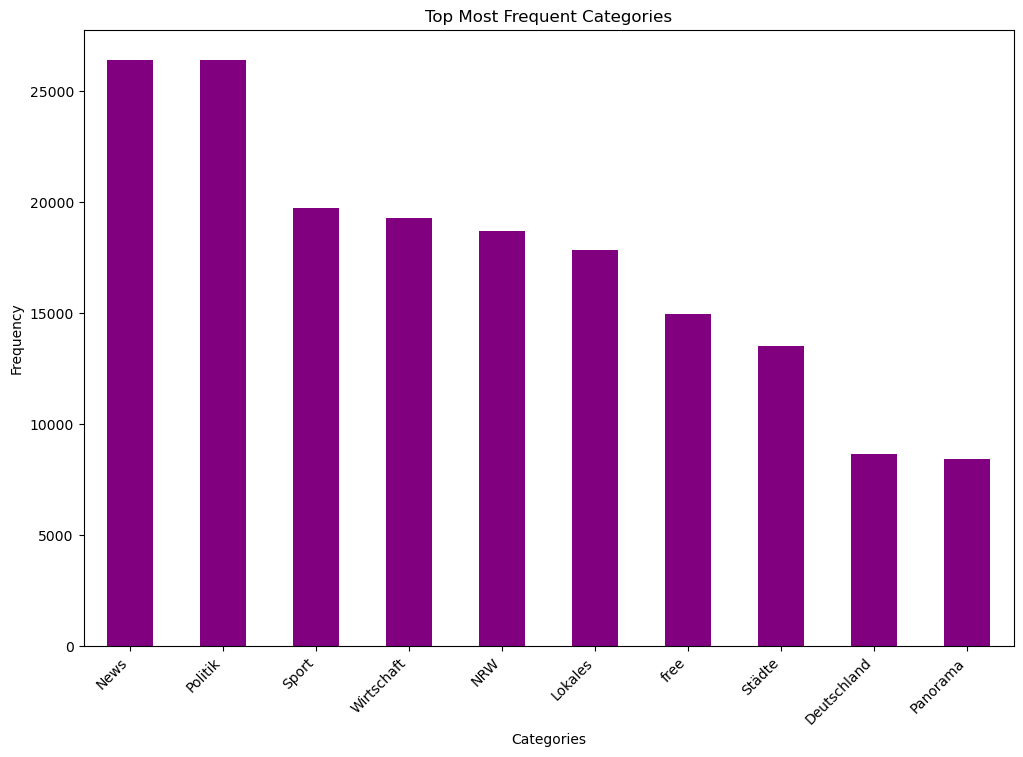

In [20]:
# Create a bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))  # Set figure size
top_categories.plot(kind='bar', color='purple')
plt.title('Top Most Frequent Categories')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate category labels for better readability
plt.show()

In [22]:
import pandas as pd
from sklearn.utils import resample


def preprocess_and_balance(df,
                           text_column='clean_text',
                           label_column='category',
                           target_count=5000,
                           top_n_categories=30):
    """
    Preprocess the dataset by converting text to lowercase and balancing the top N categories.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the dataset with text and label columns.
    - text_column (str): The name of the column containing the text data.
    - label_column (str): The name of the column containing the label/category.
    - target_count (int): The target number of samples for each category to balance.
    - top_n_categories (int): Number of top categories to balance.

    Returns:
    - pd.DataFrame: A balanced DataFrame with text converted to lowercase.
    """

    # Convert text to lowercase (using .loc to avoid SettingWithCopyWarning)
    df2 = df.copy()  # Create a copy to avoid modifying the original DataFrame
    df2.loc[:, text_column] = df2[text_column].str.lower()

    # Get the top N categories by frequency
    top_categories = df2[label_column].value_counts().nlargest(top_n_categories).index

    # Filter dataset to include only the top N categories
    df_top = df2[df2[label_column].isin(top_categories)]

    # Initialize a list to store balanced data
    balanced_data = []

    # For each category in top N categories, apply resampling
    for category in top_categories:
        category_data = df_top[df_top[label_column] == category]

        # If the category has fewer samples than target_count, oversample
        if len(category_data) < target_count:
            category_data_resampled = resample(
                category_data,
                replace=True,  # Oversample by allowing duplicates
                n_samples=target_count,
                random_state=42
            )
        # If the category has more samples than target_count, undersample
        else:
            category_data_resampled = resample(
                category_data,
                replace=False,  # Undersample without duplicates
                n_samples=target_count,
                random_state=42
            )

        # Append the resampled data
        balanced_data.append(category_data_resampled)

    # Concatenate all balanced data into a single DataFrame
    balanced_df = pd.concat(balanced_data).reset_index(drop=True)

    return balanced_df


# Choose the number of inputs raws

In [24]:
# Choose the number of inputs
target_count=100

In [27]:
# Assuming your original DataFrame is `df`
balanced_df = preprocess_and_balance(df,
                                     text_column='clean_text',
                                     label_column='category',
                                     target_count=target_count,
                                     top_n_categories=10)

# Check class distribution in the balanced dataset
print(balanced_df['category'].value_counts())
balanced_df.head()

category
News           100
Politik        100
Sport          100
Wirtschaft     100
NRW            100
Lokales        100
free           100
Städte         100
Deutschland    100
Panorama       100
Name: count, dtype: int64


,news_ID,clean_text,category
0,NID_2023-01-13-20_9793,mit wir der sein so ein yin yang geschichte pe...,News
1,NID_2023-02-04-09_3988,hoch lawinengefahren winterwetter sorgen weite...,News
2,NID_2023-01-10-08_1639,berliner autofahrer stehen 71h jahr in der sta...,News
3,NID_2023-01-17-20_16160,ybbstal schwierige zeit für kultur rückgang nu...,News
4,NID_2023-01-19-16_14204,tennis djokovic in 3 melbourne runde aus für z...,News


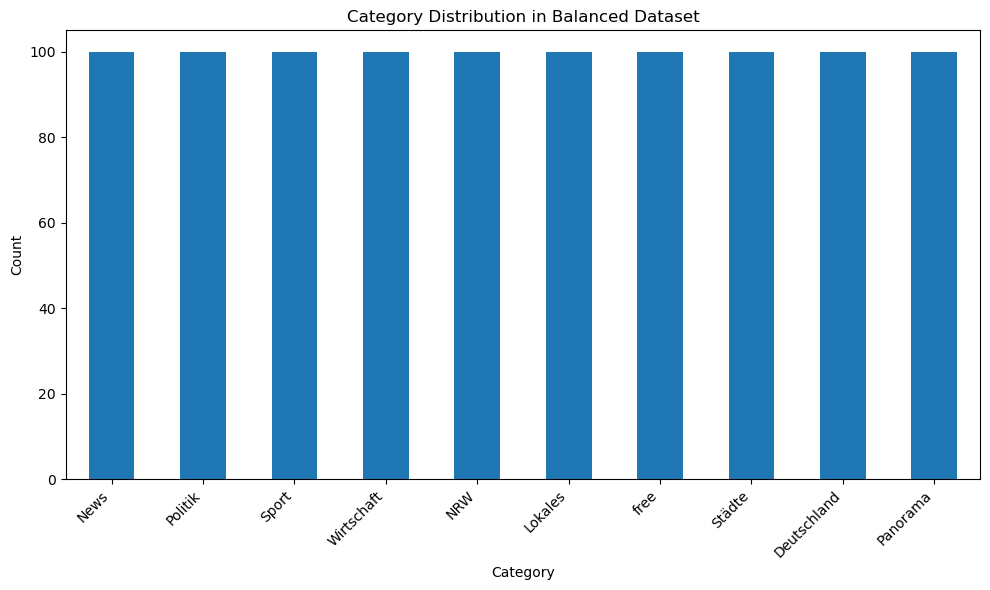

In [28]:
def plot_category_distribution(df, label_column='category'):
    """
    Plots the distribution of categories in a bar chart.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the balanced dataset.
    - label_column (str): The name of the column containing the label/category.
    """
    # Get the category counts
    category_counts = df[label_column].value_counts()

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    category_counts.plot(kind='bar')
    plt.title('Category Distribution in Balanced Dataset')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Assuming your balanced DataFrame is `balanced_df`
plot_category_distribution(balanced_df, label_column='category')

# Conventional Classification

In [32]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import make_classification
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming balanced_df is your balanced DataFrame
X = balanced_df['clean_text']  # Features (text data)
y = balanced_df['category']    # Target labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)
# Fit on the training data only
X_train_tfidf = tfidf.fit_transform(X_train)
# Transform the test set using the fitted vectorizer
X_test_tfidf = tfidf.transform(X_test)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

# Initialize classifiers
classifiers = {
   "Logistic Regression": LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42),
   # "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
   # "Support Vector Machine": SVC(kernel='linear', probability=True, random_state=42)
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))



(800, 5000)
(200, 5000)
Logistic Regression Accuracy: 0.37
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

 Deutschland       0.44      0.35      0.39        20
     Lokales       0.35      0.65      0.46        20
         NRW       0.29      0.25      0.27        20
        News       0.33      0.20      0.25        20
    Panorama       0.35      0.35      0.35        20
     Politik       0.28      0.35      0.31        20
       Sport       0.62      0.65      0.63        20
      Städte       0.38      0.30      0.33        20
  Wirtschaft       0.35      0.35      0.35        20
        free       0.31      0.25      0.28        20

    accuracy                           0.37       200
   macro avg       0.37      0.37      0.36       200
weighted avg       0.37      0.37      0.36       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


# NN Classification

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import tensorflow as tf
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW, BertConfig
from transformers import DataCollatorWithPadding
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [37]:
# Convert categories to numeric labels
balanced_df['category'] = pd.factorize(balanced_df['category'])[0]
num_labels = balanced_df['category'].nunique()
print(num_labels)

10


In [39]:
train_df, val_df = train_test_split(balanced_df, 
                                    test_size=0.2, 
                                    random_state=42, stratify=balanced_df['category'])

In [41]:
# Load BERT tokenizer and model for sequence classification
model_name = 'bert-base-german-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [43]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
# Define a custom dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

In [47]:
# Create training and validation datasets
train_dataset = TextDataset(train_df['clean_text'], train_df['category'], tokenizer)
val_dataset = TextDataset(val_df['clean_text'], val_df['category'], tokenizer)


In [49]:
# Set up the data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [51]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
)

/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [54]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

/var/folders/x6/bsynr2_s6c989vpwkw_95r840000gn/T/ipykernel_58432/8752782.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [57]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,1.857037


TrainOutput(global_step=200, training_loss=2.1417161560058595, metrics={'train_runtime': 1941.8413, 'train_samples_per_second': 0.412, 'train_steps_per_second': 0.103, 'total_flos': 210503963443200.0, 'train_loss': 2.1417161560058595, 'epoch': 1.0})

In [59]:
# Evaluate the model
predictions = trainer.predict(val_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), axis=1)

# Display classification report
print(classification_report(val_df['category'], preds))

              precision    recall  f1-score   support

           0       0.67      0.10      0.17        20
           1       0.39      0.70      0.50        20
           2       0.54      0.65      0.59        20
           3       0.50      0.75      0.60        20
           4       0.43      0.50      0.47        20
           5       0.62      1.00      0.77        20
           6       0.14      0.05      0.07        20
           7       0.30      0.15      0.20        20
           8       0.33      0.20      0.25        20
           9       0.30      0.35      0.33        20

    accuracy                           0.45       200
   macro avg       0.42      0.44      0.39       200
weighted avg       0.42      0.45      0.39       200

